In [14]:
import numpy as np
import os
import pathlib
import random
import torch
import pytorch3d.transforms
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [15]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [16]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
pass

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [17]:
learnable_robot_model.print_link_names()

base
trunk
imu_link
FR_hip
FR_thigh_shoulder
FR_thigh
FR_calf
FR_foot
FL_hip
FL_thigh_shoulder
FL_thigh
FL_calf
FL_foot
RR_hip
RR_thigh_shoulder
RR_thigh
RR_calf
RR_foot
RL_hip
RL_thigh_shoulder
RL_thigh
RL_calf
RL_foot


In [18]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")

image_robot_mapping = {'FL_Ankle': "FL_foot",
                       'FR_Ankle': "FR_foot",
                       'FL_Knee': "FL_calf",
                       'FR_Knee': "FR_calf",
                       'BL_Ankle': "RR_foot",
                       'BR_Ankle': "RL_foot",
                       'BL_Knee': "RR_calf", 
                       'BR_Knee': "RL_calf", 
                       "Hip": "RR_hip", 
                       "Shoulder":"FL_thigh_shoulder"}
training_keypoints = list(image_robot_mapping.keys())
robot_joints_for_training = [image_robot_mapping[k] for k in training_keypoints]
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
img_path = base_dir / "HorseInferenceFiles"
imageNames = ["img0088.png", "img0228.png", "img0288.png", "img0484.png"]
dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
poses = []
images = []
imgCount = len(imageNames)
for index, imageName in enumerate(imageNames):
    img_path = base_dir / "HorseInferenceFiles"/ imageName
    
    image = cv2.imread(str(img_path))    
    images.append(image)
    if index == 0:
        pose = dlc_live.init_inference(image)
    else:
        pose = dlc_live.get_pose(image)
    pose = pose[indices_keypoints_training][:,0:2]
    pose = torch.from_numpy(pose).unsqueeze(0)
    poses.append(pose)
# X,Y coords of selected keypoints
training_data = torch.vstack(poses)
training_data.shape

torch.Size([4, 10, 2])

In [19]:
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

## Training Loop

Starting Training
Epoch 0: Loss (3989.083251953125)
Epoch 0: Loss (3989.083251953125)
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)
Drawing base
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)


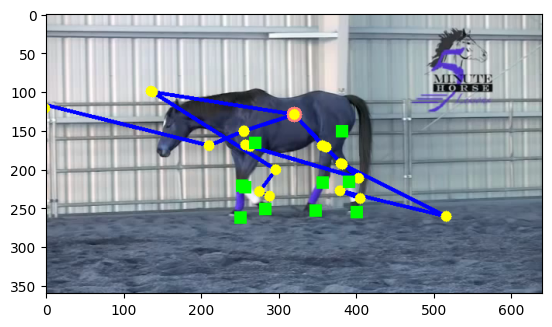

Passed Epoch 0
Passed Epoch 1
Epoch 100: Loss (778.3025512695312)
Epoch 200: Loss (742.3385620117188)
Epoch 300: Loss (735.3645629882812)
Epoch 400: Loss (734.515380859375)
Epoch 500: Loss (719.2841796875)
Epoch 600: Loss (716.2857666015625)
Epoch 700: Loss (717.2732543945312)
Epoch 800: Loss (716.1405639648438)
Epoch 900: Loss (715.3538208007812)
Epoch 1000: Loss (714.71484375)
Epoch 1000: Loss (714.71484375)
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)
Drawing base
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)


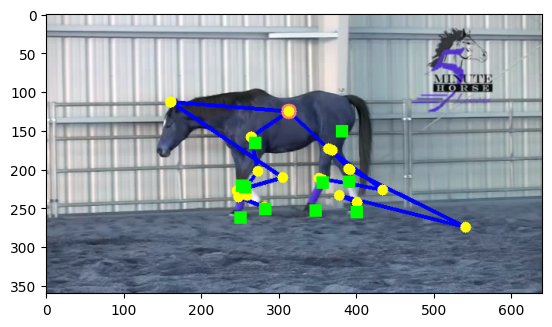

Epoch 1100: Loss (714.1535034179688)
Epoch 1200: Loss (713.5782470703125)
Epoch 1300: Loss (713.0653686523438)
Epoch 1400: Loss (712.5638427734375)
Epoch 1500: Loss (712.086669921875)
Epoch 1600: Loss (711.64208984375)
Epoch 1700: Loss (711.2139282226562)
Epoch 1800: Loss (710.83544921875)
Epoch 1900: Loss (710.45849609375)
Epoch 2000: Loss (710.1112670898438)
Epoch 2000: Loss (710.1112670898438)
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)
Drawing base
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)


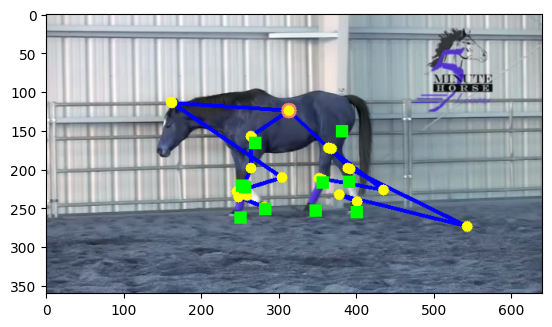

Epoch 2100: Loss (709.8142700195312)
Epoch 2200: Loss (709.5491333007812)
Epoch 2300: Loss (709.3233032226562)
Epoch 2400: Loss (709.0440063476562)
Epoch 2500: Loss (708.6060791015625)
Epoch 2600: Loss (708.1502075195312)
Epoch 2700: Loss (707.725341796875)
Epoch 2800: Loss (707.3328247070312)
Epoch 2900: Loss (706.9474487304688)
Epoch 3000: Loss (706.5556640625)
Epoch 3000: Loss (706.5556640625)
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)
Drawing base
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)


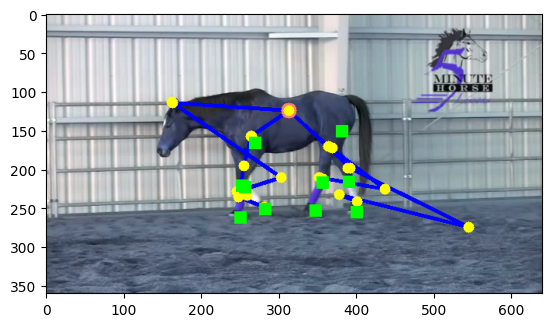

Epoch 3100: Loss (706.197265625)
Epoch 3200: Loss (705.8287963867188)
Epoch 3300: Loss (705.485595703125)
Epoch 3400: Loss (705.1411743164062)


KeyboardInterrupt: 

In [37]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]


init_angles = torch.tensor([ 0.3, -0.1, -0.3,  0.2, -0.1, -0.6, -1.1,  0.0, 0.0,
          -0.5, -0.2, -0.4])
init_angles = init_angles.repeat(imgCount,1)
joint_angles = init_angles.requires_grad_(True)

constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)

fx = differentiableConstantTensor(1)
fy  = differentiableConstantTensor(1)
u0 = differentiableConstantTensor(320)
v0 = differentiableConstantTensor(130)



tx = torch.ones((imgCount,))*0
tx = tx.requires_grad_(True)
ty = torch.ones((imgCount,))*0
ty = ty.requires_grad_(True)
tz = torch.ones((imgCount,))*1
tz = tz.requires_grad_(True)


extrinsicRotationQuaternion = torch.tensor([-0.778, -0.084,  0.627, -0.107])
extrinsicRotationQuaternion = extrinsicRotationQuaternion.unsqueeze(0) * torch.ones((imgCount,4))
extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)

%matplotlib inline
VERBOSE = True

optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
robotEEPositions = None
for epoch in range(20*1000):
    optimizer.zero_grad()
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(4,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_for_training])
    def calculateCameraProjection(intrinsic, extrinsic, jointPositions):
        transform = intrinsic@extrinsic
        pixelPositions = transform@(homogenize_vectors(jointPositions).transpose(1,2))
        pixelPositions = pixelPositions.transpose(1,2)
        pixelPositions = dehomogenize_vector(pixelPositions)
        return pixelPositions
    jointCameraPositions = calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data).reshape(-1,2)), 2),-1)))



    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
    n = 1000
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
        img = (images[0]).copy()
        print(f"Plotted Image Size: {img.shape}")
        positionByJoint = torch.cat([v[0].unsqueeze(0) if len(v.shape) >= 2 else v.unsqueeze(0) for v in robotEEPositions.values()])
        #
        allJointPosiitons = calculateCameraProjection(intrinsic, extrinsic, positionByJoint.unsqueeze(0).repeat(imgCount,1,1))[0]
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//4)
        #Draw Robot Joints
        print(f"Plotted Image Size: {img.shape}")
        for joint in jointToCameraPosition:
            jointPositionTensor = jointToCameraPosition[joint]
            color = (255,255,0)
            dotSize = size//2
            if joint == "base":
                print("Drawing base")
                color = (255,124,124)
                dotSize = int(dotSize*1.5)
            jointPosition = jointPositionTensor.clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),dotSize,color,-1)
        #Draw Keypoints
        print(f"Plotted Image Size: {img.shape}")
        for x,y in training_data[0]:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        images.append(img)
        plt.clf()
        print(f"Plotted Image Size: {img.shape}")
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()
    if epoch == 0:
        print("Passed Epoch 0")
    if epoch == 1:
        print("Passed Epoch 1")


In [ ]:
#+ list(learnable_robot_model.parameters())

In [26]:
tx,ty,tz,extrinsicRotationQuaternion, joint_angles

(tensor([0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0.], requires_grad=True),
 tensor([1., 1., 1., 1.], requires_grad=True),
 tensor([[-0.778, -0.084,  0.627, -0.107],
         [-0.789, -0.082,  0.628, -0.105],
         [-0.784, -0.084,  0.624, -0.107],
         [-0.783, -0.084,  0.624, -0.107]], requires_grad=True),
 tensor([[ 0.313, -0.114, -0.294,  0.231, -0.116, -0.624, -1.116,  0.014, -0.193,
          -0.540, -0.173, -0.371],
         [ 0.315, -0.122, -0.466,  0.233, -0.117, -0.191, -1.110,  0.021, -0.237,
          -0.539, -0.179, -0.437],
         [ 0.315, -0.119, -0.669,  0.237, -0.122, -0.374, -1.103,  0.025, -0.643,
          -0.546, -0.181, -0.070],
         [ 0.315, -0.117, -0.406,  0.231, -0.117, -0.699, -1.114,  0.016, -0.195,
          -0.541, -0.178, -0.549]], requires_grad=True))

In [29]:
jointToCameraPosition

{'base': tensor([320., 130.], grad_fn=<SelectBackward0>),
 'trunk': tensor([320., 130.], grad_fn=<SelectBackward0>),
 'imu_link': tensor([320., 130.], grad_fn=<SelectBackward0>),
 'FR_hip': tensor([52.377, 49.208], grad_fn=<SelectBackward0>),
 'FR_thigh_shoulder': tensor([50.458, 48.347], grad_fn=<SelectBackward0>),
 'FR_thigh': tensor([287.606, 178.463], grad_fn=<SelectBackward0>),
 'FR_calf': tensor([247.396, 199.885], grad_fn=<SelectBackward0>),
 'FR_foot': tensor([260.380, 205.232], grad_fn=<SelectBackward0>),
 'FL_hip': tensor([268.678, 137.562], grad_fn=<SelectBackward0>),
 'FL_thigh_shoulder': tensor([270.066, 138.210], grad_fn=<SelectBackward0>),
 'FL_thigh': tensor([400.808, 226.624], grad_fn=<SelectBackward0>),
 'FL_calf': tensor([250.656, 203.998], grad_fn=<SelectBackward0>),
 'FL_foot': tensor([283.082, 217.216], grad_fn=<SelectBackward0>),
 'RR_hip': tensor([366.387, 163.878], grad_fn=<SelectBackward0>),
 'RR_thigh_shoulder': tensor([371.268, 165.816], grad_fn=<SelectBackw